In [1]:
from matplotlib.pyplot import rc
rc('figure', facecolor='white')

# qnlp-experiment

In this notebook, we adapt the [small-scale QNLP experiment tutorial](https://discopy.readthedocs.io/en/main/notebooks/alice-loves-bob.html).
We're going to add some `Charlie` and some `hate` into the mix.

In [2]:
from discopy import Ty, Word

s, n = Ty('s'), Ty('n')

Alice = Word('Alice', n)
Bob = Word('Bob', n)
Charlie = Word('Charlie', n)
# Diane = Word('Diane', n)

loves = Word('loves', n.r @ s @ n.l)
hates = Word('hates', n.r @ s @ n.l)

who = Word('who', n.r @ n @ s.l @ n)
is_rich = Word('is rich', n.r @ s)

vocab = [Alice, loves, hates, Charlie, Bob, who, is_rich]

In [3]:
from time import time
from discopy.grammar import brute_force

gen, n_sentences = brute_force(*vocab), 40
sentences, parsing = list(), dict()

print("Brute force search for grammatical sentences:")

start = time()
for i in range(n_sentences):
    diagram = next(gen)
    sentence = ' '.join(str(w)
        for w in diagram.boxes if isinstance(w, Word)) + '.'
    sentences.append(sentence)
    parsing.update({sentence: diagram})
    print(sentence)

print("\n{:.2f} seconds to generate {} sentences.".format(time() - start, n_sentences))

Brute force search for grammatical sentences:
Alice is rich.
Charlie is rich.
Bob is rich.
Alice loves Alice.
Alice loves Charlie.
Alice loves Bob.
Alice hates Alice.
Alice hates Charlie.
Alice hates Bob.
Charlie loves Alice.
Charlie loves Charlie.
Charlie loves Bob.
Charlie hates Alice.
Charlie hates Charlie.
Charlie hates Bob.
Bob loves Alice.
Bob loves Charlie.
Bob loves Bob.
Bob hates Alice.
Bob hates Charlie.
Bob hates Bob.
Alice who is rich is rich.
Charlie who is rich is rich.
Bob who is rich is rich.
Alice who loves Alice is rich.
Alice who loves Charlie is rich.
Alice who loves Bob is rich.
Alice who hates Alice is rich.
Alice who hates Charlie is rich.
Alice who hates Bob is rich.
Alice who is rich loves Alice.
Alice who is rich loves Charlie.
Alice who is rich loves Bob.
Alice who is rich hates Alice.
Alice who is rich hates Charlie.
Alice who is rich hates Bob.
Charlie who loves Alice is rich.
Charlie who loves Charlie is rich.
Charlie who loves Bob is rich.
Charlie who hat

Diagram for 'Alice who loves Bob is rich.':


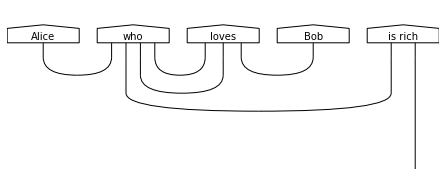

In [4]:
from discopy.grammar import draw
print("Diagram for 'Alice who loves Bob is rich.':")
draw(parsing['Alice who loves Bob is rich.'], draw_type_labels=False)

Circuit for the GHZ state, used as ansatz for "who":


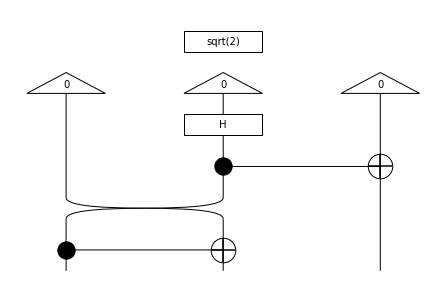

In [5]:
from discopy.quantum import Circuit, sqrt, Ket, H, Rx, CX, SWAP

# Ansatz for words with type `n`, e.g. 'Alice', 'Bob', 'Charlie'
def intransitive_ansatz(phase):
    return Ket(0) >> Rx(phase)

# Ansatz for words with type `n.r @ s @ n.l`, e.g. 'loves', 'hates'
def transitive_ansatz(phase):
    return sqrt(2) @ Ket(0, 0) >> H @ Rx(phase) >> CX

GHZ = sqrt(2) @ Ket(0, 0, 0)\
    >> Circuit.id(1) @ H @ Circuit.id(1)\
    >> Circuit.id(1) @ CX\
    >> (SWAP >>  CX) @ Circuit.id(1)

print("Circuit for the GHZ state, used as ansatz for \"who\":")
GHZ.draw(aspect='auto', draw_type_labels=False)

Circuit for 'Alice who loves Bob is rich.':


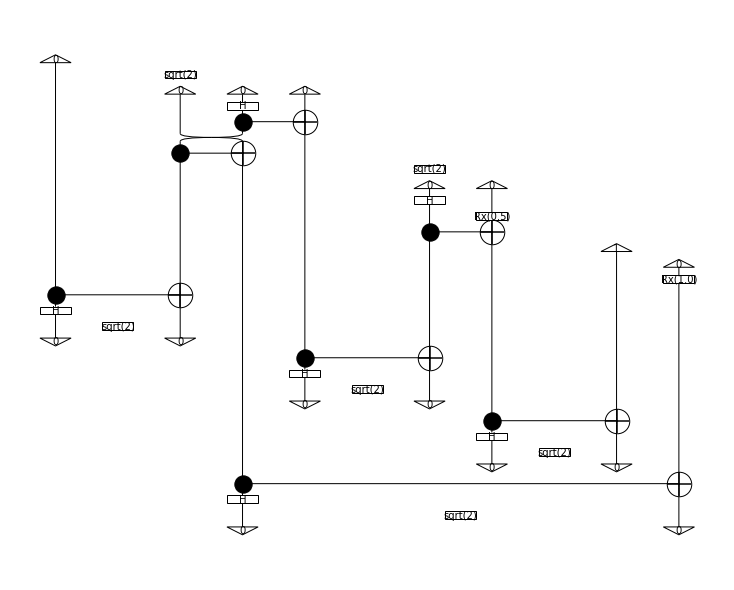

In [6]:
import numpy as np
from discopy import CircuitFunctor, qubit

F = lambda params: CircuitFunctor(
    ob={s: qubit ** 0, n: qubit ** 1},
    ar={Alice: Ket(0),
        loves: transitive_ansatz(params[0]),
        hates: transitive_ansatz(params[0]-0.5),
        Bob: Ket(1),
        Charlie: Ket(1),
        who: GHZ,
        is_rich: intransitive_ansatz(params[1])})

params0 = np.array([0.5, 1])
print("Circuit for 'Alice who loves Bob is rich.':")
circuit = F(params0)(parsing['Alice who loves Bob is rich.'])
circuit.draw(figsize=(10, 8), aspect='auto', draw_type_labels=False)

In [7]:
from pytket.extensions.qiskit import tk_to_qiskit

tk_circ = circuit.to_tk()
print("{}:\n{}\n".format(tk_circ, '\n'.join(map(str, tk_circ))))
print("post selection:\n{}\n".format(tk_circ.post_selection))
print("scalar:\n{}\n".format(tk_circ.scalar))
print("qiskit circuit:")
tk_to_qiskit(tk_circ).draw()

<tket::Circuit, qubits=8, gates=24>:
H q[1];
H q[4];
Rx(1) q[5];
X q[6];
Rx(2) q[7];
CX q[1], q[3];
CX q[4], q[5];
CX q[1], q[2];
CX q[3], q[4];
CX q[5], q[6];
Measure q[4] --> c[3];
Measure q[6] --> c[5];
CX q[0], q[1];
CX q[2], q[7];
H q[3];
H q[5];
Measure q[1] --> c[1];
Measure q[3] --> c[2];
Measure q[5] --> c[4];
Measure q[7] --> c[7];
H q[0];
H q[2];
Measure q[0] --> c[0];
Measure q[2] --> c[6];

post selection:
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}

scalar:
64.00000000000009

qiskit circuit:


┌───┐                   ┌─┐   
q_0: ──────────────────────■──┤ H ├───────────────────┤M├───
       ┌───┐             ┌─┴─┐└───┘     ┌─┐           └╥┘   
q_1: ──┤ H ├─────■────■──┤ X ├──────────┤M├────────────╫────
       └───┘     │  ┌─┴─┐└───┘          └╥┘┌───┐       ║ ┌─┐
q_2: ────────────┼──┤ X ├────────────■───╫─┤ H ├───────╫─┤M├
               ┌─┴─┐└───┘┌───┐       │   ║ └┬─┬┘       ║ └╥┘
q_3: ──────────┤ X ├──■──┤ H ├───────┼───╫──┤M├────────╫──╫─
       ┌───┐   └───┘┌─┴─┐└┬─┬┘       │   ║  └╥┘        ║  ║ 
q_4: ──┤ H ├─────■──┤ X ├─┤M├────────┼───╫───╫─────────╫──╫─
     ┌─┴───┴─┐ ┌─┴─┐└───┘ └╥┘ ┌───┐  │   ║   ║  ┌─┐    ║  ║ 
q_5: ┤ Rx(π) ├─┤ X ├──■────╫──┤ H ├──┼───╫───╫──┤M├────╫──╫─
     └─┬───┬─┘ └───┘┌─┴─┐  ║  └┬─┬┘  │   ║   ║  └╥┘    ║  ║ 
q_6: ──┤ X ├────────┤ X ├──╫───┤M├───┼───╫───╫───╫─────╫──╫─
     ┌─┴───┴──┐     └───┘  ║   └╥┘ ┌─┴─┐ ║   ║   ║ ┌─┐ ║  ║ 
q_7: ┤ Rx(2π) ├────────────╫────╫──┤ X ├─╫───╫───╫─┤M├─╫──╫─
     └────────┘            ║    ║  └───┘ ║   ║   ║ └╥┘ ║  ║ 
c: 8/══════════════════════╩════╩════════╩═══╩═══╩══╩══╩══╩═
                           3    5        1   2   4  7  0  6

In [8]:
def evaluate(params, sentences, backend, n_shots=2**10, seed=0):
    circuits = [F(params)(parsing[s]) for s in sentences]
    results = [Circuit.eval(
                circuit,
                backend=backend,
                n_shots=n_shots,
                seed=seed,
                compilation=backend.default_compilation_pass(2)) for circuit in circuits]
    tensors = [np.abs(result.array)[0] for result in results]
    return tensors

In [9]:
from pytket.extensions.qiskit import AerBackend

start = time()
corpus = dict(zip(sentences, evaluate(params0, sentences, backend=AerBackend())))
print("{:.3f} seconds to compute the corpus.\n".format(time() - start))

delta = .01

print("True sentences:\n{}\n".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if scalar > .5 + delta)))
print("False sentences:\n{}\n".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if scalar < .5 - delta)))
print("Maybe sentences:\n{}".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if .5 - delta <= scalar <= .5 + delta)))

7.520 seconds to compute the corpus.

True sentences:
Alice is rich. (1.035)
Alice loves Charlie. (1.125)
Alice loves Bob. (1.125)
Alice hates Alice. (1.125)
Charlie loves Alice. (1.125)
Charlie hates Charlie. (1.125)
Charlie hates Bob. (1.125)
Bob loves Alice. (1.125)
Bob hates Charlie. (1.125)
Bob hates Bob. (1.125)
Alice who is rich is rich. (1.188)
Alice who loves Charlie is rich. (1.000)
Alice who loves Bob is rich. (1.000)
Alice who hates Alice is rich. (1.000)
Alice who is rich loves Charlie. (1.000)
Alice who is rich loves Bob. (1.000)
Alice who is rich hates Alice. (1.000)

False sentences:
Charlie is rich. (0.000)
Bob is rich. (0.000)
Alice loves Alice. (0.000)
Alice hates Charlie. (0.000)
Alice hates Bob. (0.000)
Charlie loves Charlie. (0.000)
Charlie loves Bob. (0.000)
Charlie hates Alice. (0.000)
Bob loves Charlie. (0.000)
Bob loves Bob. (0.000)
Bob hates Alice. (0.000)
Charlie who is rich is rich. (0.000)
Bob who is rich is rich. (0.000)
Alice who loves Alice is rich. (0.

In [10]:
from sklearn.model_selection import train_test_split

sentence_train, sentence_test = train_test_split(sentences, test_size=0.5, random_state=237)

print("Training set:\n{}\n".format('\n'.join(sentence_train)))
print("Testing set:\n{}".format('\n'.join(sentence_test)))

Training set:
Charlie is rich.
Alice who is rich loves Bob.
Bob who is rich is rich.
Charlie loves Charlie.
Bob hates Bob.
Charlie who loves Charlie is rich.
Alice loves Bob.
Alice is rich.
Alice who is rich loves Alice.
Alice who loves Alice is rich.
Charlie who loves Bob is rich.
Alice hates Alice.
Alice loves Charlie.
Alice hates Charlie.
Bob loves Bob.
Charlie hates Alice.
Alice hates Bob.
Charlie loves Alice.
Alice loves Alice.
Bob is rich.

Testing set:
Charlie who is rich is rich.
Alice who hates Bob is rich.
Bob loves Charlie.
Alice who is rich is rich.
Alice who is rich loves Charlie.
Alice who hates Alice is rich.
Alice who is rich hates Alice.
Alice who loves Charlie is rich.
Alice who loves Bob is rich.
Charlie who hates Alice is rich.
Bob hates Charlie.
Charlie who loves Alice is rich.
Charlie hates Charlie.
Alice who is rich hates Bob.
Charlie hates Bob.
Alice who is rich hates Charlie.
Bob hates Alice.
Charlie loves Bob.
Bob loves Alice.
Alice who hates Charlie is rich.


In [11]:
def loss(params, sentences=sentence_train):
    return - np.mean(np.array([
        (corpus[sentence] - scalar) ** 2
        for sentence, scalar in zip(sentences, evaluate(params, sentences, backend=AerBackend()))]))

In [12]:
from random import random, seed; seed(337)

params = np.array([random(), random(), random()])

print("Random initialisation: {}".format(params))

print("\nIs Alice who loves Bob rich?")
print("Yes, she is."
      if evaluate(params, ['Alice who loves Bob is rich.'], backend=AerBackend())[0] > .5 + delta
      else "No, she isn't.")

Random initialisation: [0.2018591  0.83909858 0.36025691]

Is Alice who loves Bob rich?
No, she isn't.


In [13]:
import noisyopt

i, start = 0, time()

def callback(params):
    global i
    i += 1
    print("Epoch {} ({:.0f} seconds since start): {}".format(i, time() - start, params))

result = noisyopt.minimizeSPSA(
    loss, params, paired=False, callback=callback, niter=10, a=2)
result

Epoch 1 (6 seconds since start): [0.2018591  0.83909858 0.36025691]
Epoch 2 (13 seconds since start): [0.45918963 0.58176806 0.61758744]
Epoch 3 (19 seconds since start): [0.56451461 0.68709304 0.51226245]
Epoch 4 (25 seconds since start): [0.63887386 0.76145229 0.58662169]
Epoch 5 (31 seconds since start): [0.42412446 0.97620168 0.3718723 ]
Epoch 6 (37 seconds since start): [0.49259215 0.90773399 0.3034046 ]
Epoch 7 (43 seconds since start): [0.52606787 0.9412097  0.33688032]
Epoch 8 (49 seconds since start): [0.52003141 0.93517324 0.34291678]
Epoch 9 (54 seconds since start): [0.47842355 0.9767811  0.30130892]
Epoch 10 (60 seconds since start): [0.49476893 0.96043572 0.28496354]


     fun: -0.00023307800292968818
 message: 'terminated after reaching max number of iterations'
    nfev: 20
     nit: 10
 success: True
       x: array([0.49476893, 0.96043572, 0.28496354])

In [14]:
print("Testing loss: {}".format(loss(result.x, sentences=sentence_test)))

Testing loss: -0.0010253906250000035


In [15]:
print("Is Alice who loves Bob rich?")
print("Yes, she is."
      if evaluate(result.x, ['Alice who loves Bob is rich.'], backend=AerBackend())[0] > .5 + delta
      else "No, she isn't.")

Is Alice who loves Bob rich?
Yes, she is.


In [16]:
print("Does Alice love Bob?")
print("Yes."
      if evaluate(result.x, ['Alice loves Bob.'], backend=AerBackend())[0] > .5 + delta
      else "No, she doesn't.")

Does Alice love Bob?
Yes.


In [17]:
print("Does Bob love Alice?")
print("Yes."
      if evaluate(result.x, ['Bob loves Alice.'], backend=AerBackend())[0] > .5 + delta
      else "No, he doesn't.")

Does Bob love Alice?
Yes.
